## Background:

3 patients were treated with Paxlovid following acute SARS-CoV2 infection.
All three of these patients experienced symptom relief, followed by a return of symtoms and positive PCR tests with low Ct value

Question: Are there any mutations of interest associated with this rebound after Paxlovid

### Metadata:

|name | source | collection-date | Ct | ddPCR | coverage | lineage|  
|-----| ----- | ----- | ----- | ----- | -----| ------ | 
|HES_CS_140|NP Swab|2022-04-20|20.7|61498.27|94.97|BA.2|
|HES_CS_144_2|NP Swab|2022-05-06|||99.35|BA.2.10|
|HES_CS_147|NP Swab|2022-05-11|||98.87|BA.2.3|
 

In [2]:
#load packages
library(ggplot2)
library(plyr)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggrepel)
library(RColorBrewer)
library(glue)
library(cowplot)
library(UpSetR)
library(pheatmap)
library(vcfR)
library(igraph)
library(ggpubr)

Warning message:
“package ‘ggplot2’ was built under R version 4.0.2”
Warning message:
“package ‘tidyverse’ was built under R version 4.0.2”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘readr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
Warning message:
“package ‘forcats’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()  

In [3]:
project_folder <- '/Users/roderae/National Institutes of Health/Ghedin, Elodie (NIH NIAID) [E] - LAB_STUFF/allison/projects/COV2-NIH/OMS/paxlovid-study'
aasnplist_folder <- glue("{project_folder}/aasnplist")

In [4]:
SEGMENTS = c('SARS-CoV2')
# Here we set the coverage cutoff to 3 for identification of consensus changes
covcutoff = 3
# The initial allele frequency is set to .5%
minfreq = 0.005
# we exclude any instances were an 'N' is called in these analyses
ntlist = c('A','G','T','C','-')

# this list of cleavage ids will be removed from the dataframe
# just want to use orf1a and orf1b rather than cleavage products
orf1 = c('nsp1','nsp2','nsp3','nsp4','nsp5','nsp6',
        'nsp7','nsp8','nsp9','nsp10','nsp11a','nsp11b',
        'nsp12','nsp13','nsp14','nsp15')

In [5]:
setwd(glue("{aasnplist_folder}"))
files <- Sys.glob(glue("*.csv"))

In [6]:
files

[1] "HES-CS-144-2.COV19.NC_045512.2.0.001.aa.snplist.csv"
[2] "HES-CS-147.COV19.NC_045512.2.0.001.aa.snplist.csv"  
[3] "HES_CS_140.COV19.NC_045512.2.0.001.aa.snplist.csv"

##### Load in variant file

In [7]:
full_list <- data.frame()

# iterate through files to count nt changes of each type in both minority variants and consensus changes
for (filename in files) {

    # read in a file, add copies/mL 
    print(filename)
    mydata <- read.csv(file=filename,header=T,sep=",",na.strings = c(''))
    #mydata$segment = factor(mydata$segment,levels=SEGMENTS)
    mydata$file = filename
    
    full_list <- rbind(full_list, mydata)
    
}

[1] "HES-CS-144-2.COV19.NC_045512.2.0.001.aa.snplist.csv"
[1] "HES-CS-147.COV19.NC_045512.2.0.001.aa.snplist.csv"
[1] "HES_CS_140.COV19.NC_045512.2.0.001.aa.snplist.csv"


### Plot coverage across the genome:

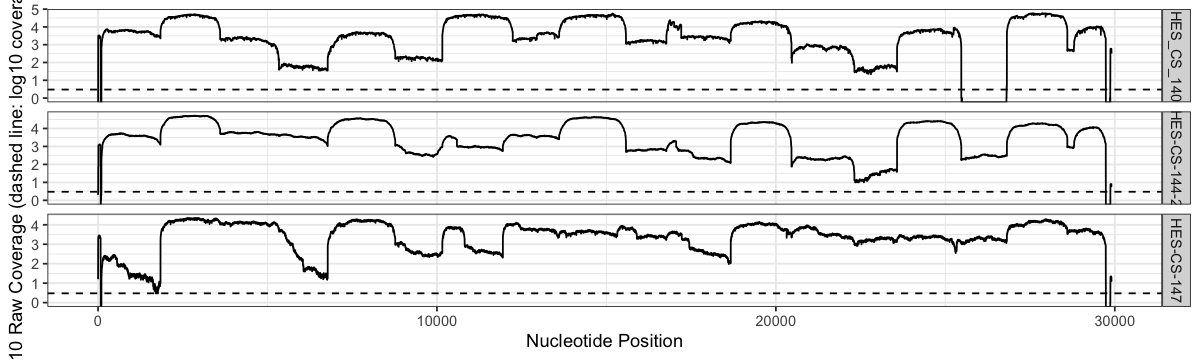

In [8]:
# plot the coverage across the samples
options(repr.plot.width=10, repr.plot.height=3)
cov1 = full_list %>%
                ggplot(.,aes(x=ntpos,y=log10(totalcount),group=name)) +
                    geom_line() +
                    geom_hline(yintercept=log10(covcutoff),linetype=2) +
                    theme_bw() +
                    ylab(glue("Log10 Raw Coverage (dashed line: log10 coverage of {covcutoff}X")) +
                    xlab("Nucleotide Position") +
                    facet_grid(name  ~., scales='free')
print(cov1)

Gap in coverage between 25471 and 26815 correlates with amplicon B8 dropout

## Potential paxlovid resistance:

A preliminary literature search did not reveal any known mutations associated with paxlivod resistance. 
Paxlovid targets the main protease of SARS-CoV-2, Mpro, also known as nsp5.

Pull out mutations in nsp5

In [9]:
mpro_changes <- full_list %>% 
                    filter(!refnt == major &
                           major %in% ntlist &
                           totalcount >= 3 &
                           majorfreq >= 0.5 &
                          gene_id == 'nsp5') %>% 
                    select(name, ntpos, major, majorfreq, binocheck, totalcount, aapos, majoraa, majorcodon, refnt, gene_id, refcodon, refaa, nonsyn, majRefSame) %>%
                    mutate(nonsyn = ifelse(majoraa == refaa, "syn", "nonsyn")) %>%
                    mutate(indel = ifelse(major == '-', "del", ifelse(refnt == '-', "ins","sub")))

mpro_changes$ntchange <- paste0(mpro_changes$gene_id,":",mpro_changes$refnt,mpro_changes$ntpos,mpro_changes$major)
mpro_changes$aachange <- paste0(mpro_changes$gene_id,":",mpro_changes$refaa,mpro_changes$aapos,mpro_changes$majoraa)

In [30]:
mpro_changes_orf1a <- full_list %>% 
                    filter(!refnt == major &
                           major %in% ntlist &
                           totalcount >= 3 &
                           majorfreq >= 0.5 &
                           ntpos %in% c(10055:11055) &
                           gene_id == 'ORF1a') %>% 
                    select(name, ntpos, major, majorfreq, binocheck, totalcount, aapos, majoraa, majorcodon, refnt, gene_id, refcodon, refaa, nonsyn, majRefSame) %>%
                    mutate(nonsyn = ifelse(majoraa == refaa, "syn", "nonsyn")) %>%
                    mutate(indel = ifelse(major == '-', "del", ifelse(refnt == '-', "ins","sub")))

mpro_changes_orf1a$ntchange <- paste0(mpro_changes_orf1a$gene_id,":",mpro_changes_orf1a$refnt,mpro_changes_orf1a$ntpos,mpro_changes_orf1a$major)
mpro_changes_orf1a$aachange <- paste0(mpro_changes_orf1a$gene_id,":",mpro_changes_orf1a$refaa,mpro_changes_orf1a$aapos,mpro_changes_orf1a$majoraa)

Warning message:
“Removed 11 rows containing missing values (position_stack).”


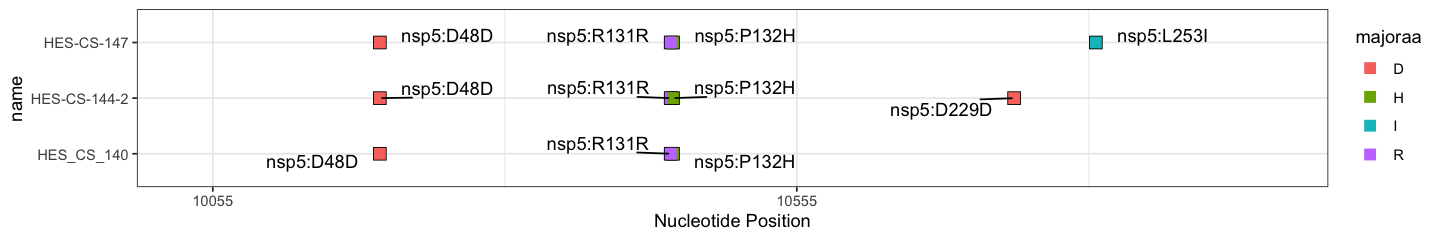

In [10]:
options(repr.plot.width=12, repr.plot.height=2)
p1 = ggplot() +

    geom_col(data = mpro_changes,
            aes(x=30000,y=name), color="#DEDEDE") +

    geom_point(data = mpro_changes,
        aes(x=ntpos,y=name), color='black', size=3.5, shape = 15) +

    geom_point(data = mpro_changes,
        aes(x=ntpos,y=name, color=majoraa), size=3, shape = 15) +

    geom_text_repel(data = mpro_changes, 
        aes(x=ntpos,y=name,label=aachange),box.padding = 0.8, max.overlaps = Inf) +

    theme_bw()+

    scale_x_continuous(name="Nucleotide Position",
                       breaks=seq(10055,10972,by=500),
                       limits=c(10000,11000),expand=c(0.01,0.01))

print(p1)

##### same plot but labeled with ORF1a coordinates

Warning message:
“Removed 11 rows containing missing values (position_stack).”


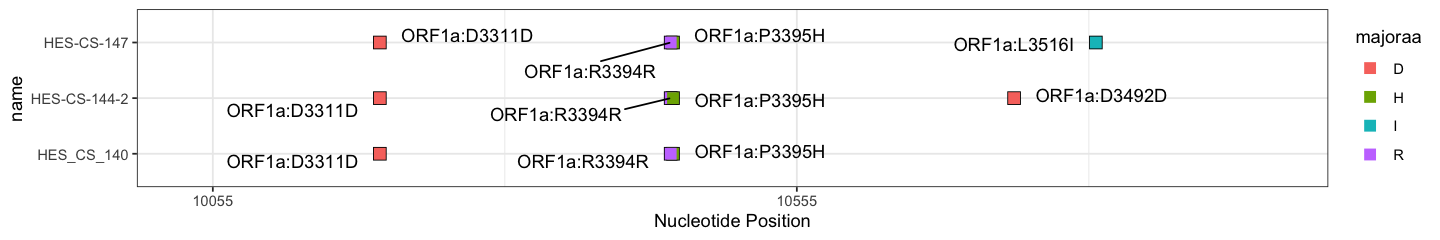

In [31]:
options(repr.plot.width=12, repr.plot.height=2)
p2 = ggplot() +

    geom_col(data = mpro_changes_orf1a,
            aes(x=30000,y=name), color="#DEDEDE") +

    geom_point(data = mpro_changes_orf1a,
        aes(x=ntpos,y=name), color='black', size=3.5, shape = 15) +

    geom_point(data = mpro_changes_orf1a,
        aes(x=ntpos,y=name, color=majoraa), size=3, shape = 15) +

    geom_text_repel(data = mpro_changes_orf1a, 
        aes(x=ntpos,y=name,label=aachange),box.padding = 0.8, max.overlaps = Inf) +

    theme_bw()+

    scale_x_continuous(name="Nucleotide Position",
                       breaks=seq(10055,10972,by=500),
                       limits=c(10000,11000),expand=c(0.01,0.01))

print(p2)

The mutations in the 131-132 region lie near the protease active site, and have some potential for impacting the protease. The P132H mutation is characteristic of omicron and is not unique to this patient. It is not likely to confer Paxlovid resistance.

The L3516I mutation is not a defining omicron mutation. 

### Plot coverage across the spike region:  

sufficient coverage across the spike region, allowing for analysis of mutations in this region

Warning message:
“Removed 140943 row(s) containing missing values (geom_path).”


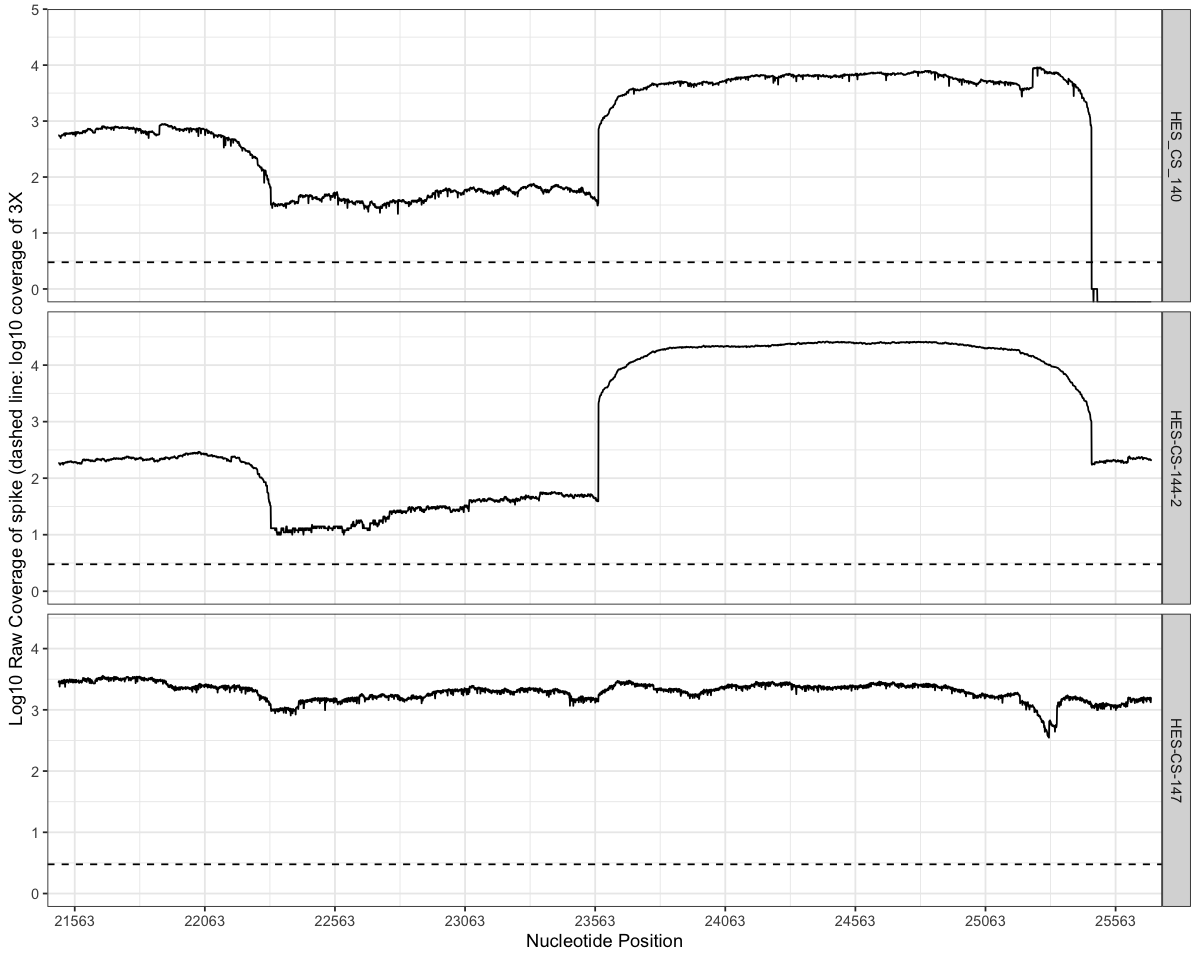

In [11]:
# plot the coverage across the samples
options(repr.plot.width=10, repr.plot.height=8)
cov2 = full_list %>%
                ggplot(.,aes(x=ntpos,y=log10(totalcount),group=name)) +
                    geom_line() +
                    geom_hline(yintercept=log10(covcutoff),linetype=2) +
                    theme_bw() +
                    ylab(glue("Log10 Raw Coverage of spike (dashed line: log10 coverage of {covcutoff}X")) +
                    xlab("Nucleotide Position") +
                    facet_grid(name  ~., scales='free') +
                    scale_x_continuous(name="Nucleotide Position",
                       breaks=seq(21563,25684,by=500),
                       limits=c(21500,25700),expand=c(0.01,0.01))
                    
print(cov2)

### Pull out mutations in the spike region

* only consensus changes (frequency greater than or equal to 50% of total reads) were considered for this analysis  
* minor variants were analyzed but nothing of note was found

In [12]:
spike_list <- full_list %>% filter(ntpos %in% (21563:25684))

spike_changes <- spike_list %>% 
                    filter(!refnt == major &
                           major %in% ntlist &
                           totalcount >= 3 &
                           majorfreq >= 0.5) %>% 
                    select(name, ntpos, major, majorfreq, binocheck, totalcount, aapos, majoraa, majorcodon, refnt, gene_id, refcodon, refaa, nonsyn, majRefSame) %>%
                    mutate(nonsyn = ifelse(majoraa == refaa, "syn", "nonsyn")) %>%
                    mutate(indel = ifelse(major == '-', "del", ifelse(refnt == '-', "ins","sub")))

spike_changes$ntchange <- paste0(spike_changes$gene_id,":",spike_changes$refnt,spike_changes$ntpos,spike_changes$major)
spike_changes$aachange <- paste0(spike_changes$gene_id,":",spike_changes$refaa,spike_changes$aapos,spike_changes$majoraa)

### Plot mutations across the spike region  

boxes indicate regions where the amino acid in the sample differs from the Wuhan/Hu-1 strain

Warning message:
“Removed 116 rows containing missing values (position_stack).”


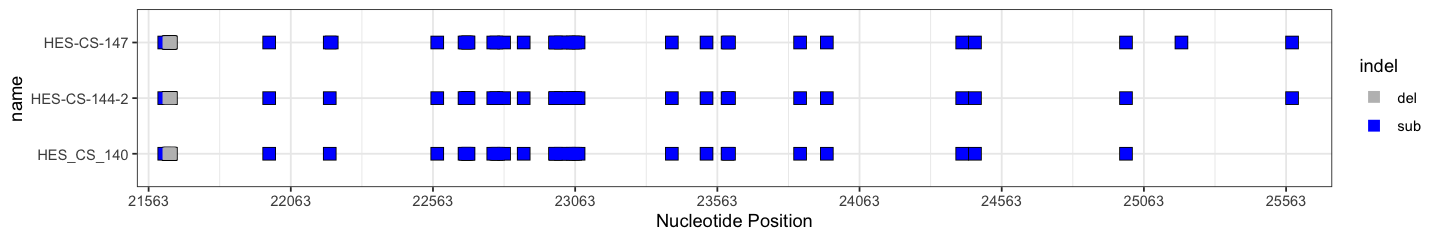

In [13]:
options(repr.plot.width=12, repr.plot.height=2)
f1 = ggplot() +

    geom_col(data = spike_changes,
            aes(x=30000,y=name), color="#DEDEDE") +

    geom_point(data = spike_changes,
        aes(x=ntpos,y=name), color='black', size=3.5, shape = 15) +

    geom_point(data = spike_changes,
        aes(x=ntpos,y=name, color=indel), size=3, shape = 15) +

    theme_bw()+

    scale_x_continuous(name="Nucleotide Position",
                       breaks=seq(21563,25684,by=500),
                       limits=c(21563,25684),expand=c(0.01,0.01)) +

    scale_colour_manual(values = c("grey","blue", "yellow"))

print(f1)

a number of mutations in the spike region exist in this patient - will look into them in more detail below

#### Look specifically for mutations associated with Sotrovimab resistance  

Neither of the mutations associated with Sotrovimab resistance were identified in this patient

In [14]:
spike_changes %>% filter(aapos %in% c(337,340)) # aa postitions 337 and 340 are associated with Sotrovimab resistance. 

name,ntpos,major,majorfreq,binocheck,totalcount,aapos,majoraa,majorcodon,refnt,gene_id,refcodon,refaa,nonsyn,majRefSame,indel,ntchange,aachange
<chr>,<int>,<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


In [15]:
spike_changes %>% filter(aapos %in% c(330:345)) 
# there is an amino acid change at position 339 however.
# This mutation is characteristic of the omicron lineage.  

name,ntpos,major,majorfreq,binocheck,totalcount,aapos,majoraa,majorcodon,refnt,gene_id,refcodon,refaa,nonsyn,majRefSame,indel,ntchange,aachange
<chr>,<int>,<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
HES-CS-144-2,22578,A,1.0000000,NA,14,339,D,gAt,G,S,ggt,G,nonsyn,False,sub,S:G22578A,S:G339D
HES-CS-147,22578,A,0.9992548,NA,1342,339,D,gAt,G,S,ggt,G,nonsyn,False,sub,S:G22578A,S:G339D
HES_CS_140,22578,A,1.0000000,NA,42,339,D,gAt,G,S,ggt,G,nonsyn,False,sub,S:G22578A,S:G339D


## All nonsynonymous mutations identified in the spike region:

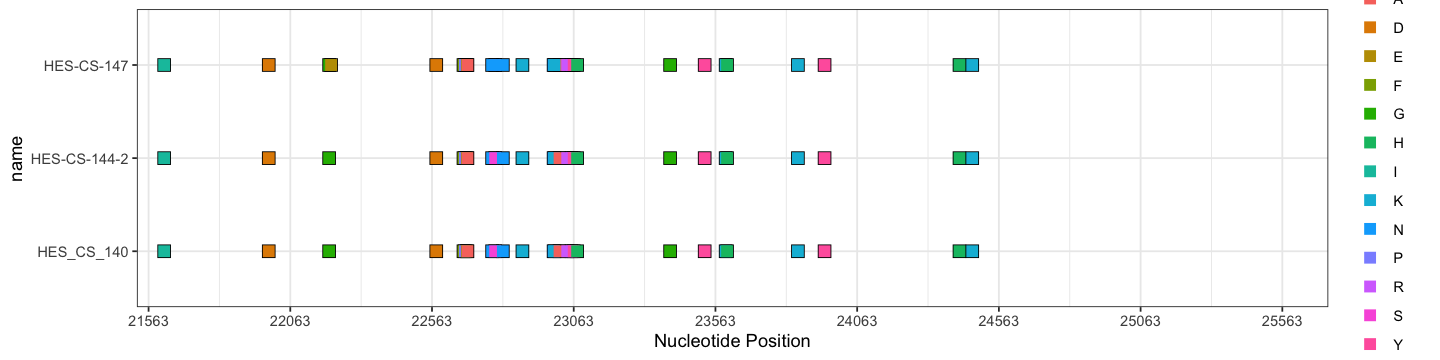

In [21]:
# plot only substitutions between initial sample and sample _4
options(repr.plot.width=12, repr.plot.height=3)
f2 = ggplot() +

    geom_point(data = subset(spike_changes, !nonsyn == 'syn'),
        aes(x=ntpos,y=name), color='black', size=3.5, shape = 15) +

    geom_point(data = subset(spike_changes, !nonsyn == 'syn'),
        aes(x=ntpos,y=name,color=majoraa), size=3, shape = 15) +

    #geom_text_repel(data = subset(spike_changes, !nonsyn == 'syn'), 
     #               aes(x=ntpos,y=name,label=aachange),box.padding = 0.8, max.overlaps = Inf) +

    theme_bw()+

    scale_x_continuous(name="Nucleotide Position",
                       breaks=seq(21563,25684,by=500),
                       limits=c(21563,25684),expand=c(0.01,0.01))

print(f2)

In [22]:
omi_con <- c('S:G142D','S:G339D','S:S373P','S:S375F','S:K417N','S:N440K',
             'S:S477N','S:T478K','S:D484A','S:E484A','S:Q493R','S:Q498R',
             'S:N501Y','S:Y505H','S:D614G','S:H655Y','S:N679K','S:P681H',
             'S:N764K','S:D796Y', 'S:Q954H', 'S:N969K')
ba2_con <- c('S:T19I','S:A27S','S:V213G','S:S371F','S:T376A','S:R408S','S:D405N')
ba1_con <- c('S:S371L')

In [23]:
spike_changes$omi <- ifelse(spike_changes$aachange %in% omi_con, "BA.1/BA.2",
                                             ifelse(spike_changes$aachange %in% ba2_con, "BA.2",
                                                   ifelse(spike_changes$aachange %in% ba1_con, "BA.1","other")))

### Many of these mutations are characteristic of the BA.2 lineage:

The below plot shows mutations present in this patient that are associated with the Omicron lineage, or with BA.2 specifically

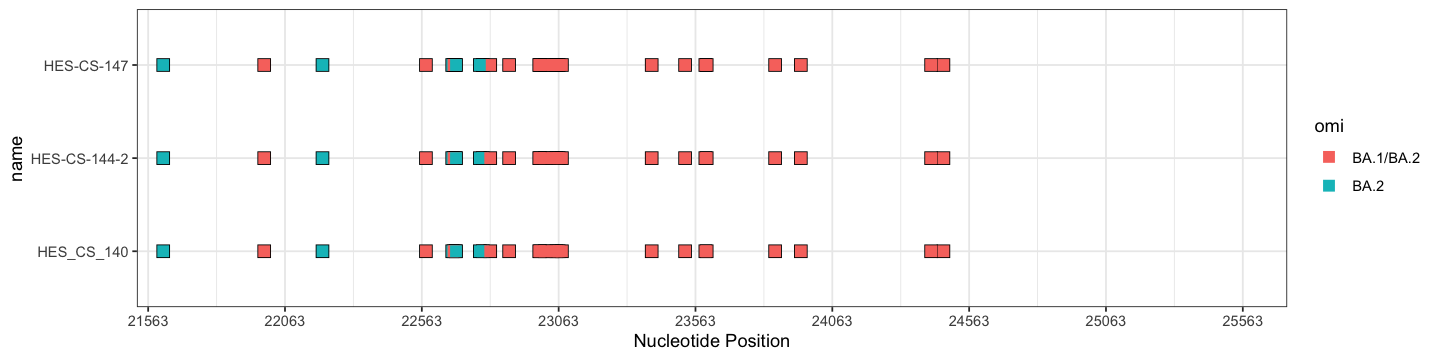

In [25]:
# plot only substitutions between initial sample and sample _4
options(repr.plot.width=12, repr.plot.height=3)
f3 = ggplot() +

    geom_point(data = subset(spike_changes, !nonsyn == 'syn' & !omi == 'other'),
        aes(x=ntpos,y=name), color='black', size=3.5, shape = 15) +

    geom_point(data = subset(spike_changes, !nonsyn == 'syn' & !omi == 'other'),
        aes(x=ntpos,y=name,color=omi), size=3, shape = 15) +

    #geom_text_repel(data = subset(spike_changes, !nonsyn == 'syn' & !omi == 'other'), 
    #                aes(x=ntpos,y=name,label=aachange),box.padding = 0.8, max.overlaps = Inf) +

    theme_bw()+

    scale_x_continuous(name="Nucleotide Position",
                       breaks=seq(21563,25684,by=500),
                       limits=c(21563,25684),expand=c(0.01,0.01))

print(f3)

### Plot mutations specifically associated with BA.2

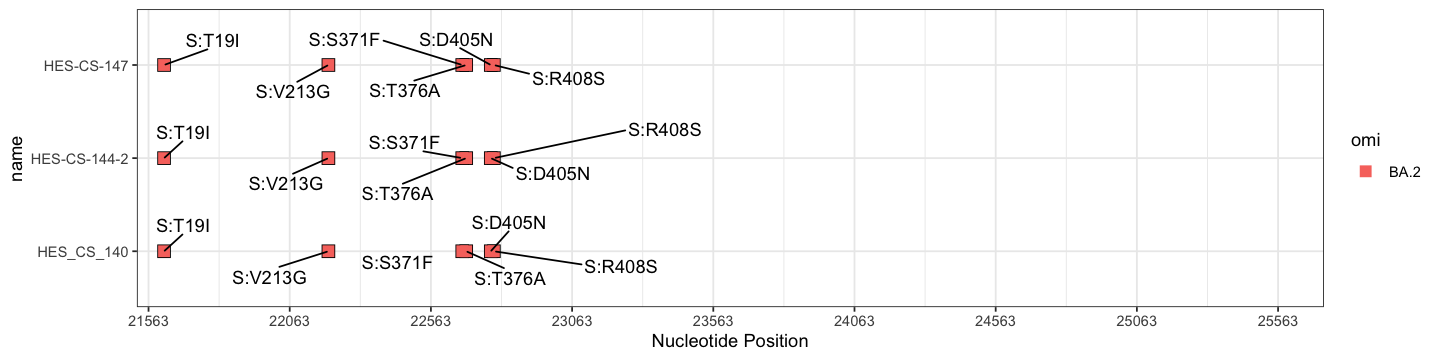

In [26]:
# plot only substitutions between initial sample and sample _4
options(repr.plot.width=12, repr.plot.height=3)
f3 = ggplot() +

    geom_point(data = subset(spike_changes, !nonsyn == 'syn' & omi == 'BA.2'),
        aes(x=ntpos,y=name), color='black', size=3.5, shape = 15) +

    geom_point(data = subset(spike_changes, !nonsyn == 'syn' & omi == 'BA.2'),
        aes(x=ntpos,y=name,color=omi), size=3, shape = 15) +

    geom_text_repel(data = subset(spike_changes, !nonsyn == 'syn' & omi == 'BA.2'), 
                    aes(x=ntpos,y=name,label=aachange),box.padding = 0.8, max.overlaps = Inf) +

    theme_bw()+

    scale_x_continuous(name="Nucleotide Position",
                       breaks=seq(21563,25684,by=500),
                       limits=c(21563,25684),expand=c(0.01,0.01))

print(f3)

### Plot mutations that are not specifically associated with Omicron lineage in the spike region:

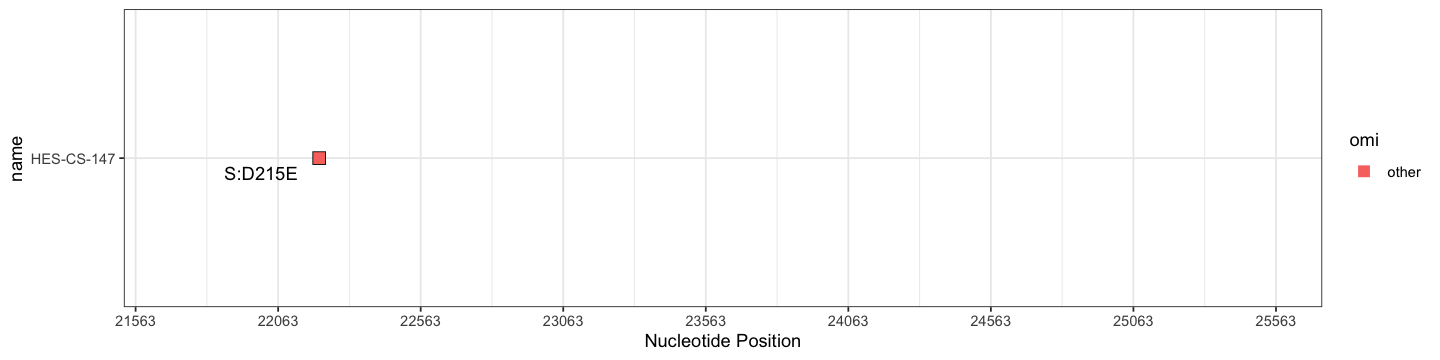

In [27]:
# plot only substitutions between initial sample and sample _4
options(repr.plot.width=12, repr.plot.height=3)
f3 = ggplot() +

    geom_point(data = subset(spike_changes, !nonsyn == 'syn' & omi == 'other'),
        aes(x=ntpos,y=name), color='black', size=3.5, shape = 15) +

    geom_point(data = subset(spike_changes, !nonsyn == 'syn' & omi == 'other'),
        aes(x=ntpos,y=name,color=omi), size=3, shape = 15) +

    geom_text_repel(data = subset(spike_changes, !nonsyn == 'syn' & omi == 'other'), 
                    aes(x=ntpos,y=name,label=aachange),box.padding = 0.8, max.overlaps = Inf) +

    theme_bw()+

    scale_x_continuous(name="Nucleotide Position",
                       breaks=seq(21563,25684,by=500),
                       limits=c(21563,25684),expand=c(0.01,0.01))

print(f3)

only one mutation in the spike region was identified that is not characteristic of the omicron lineage

## In conclusion:

Many mutations separate this patient from the Wuhan/Hu-1 reference strain, though this is to be expected based on the lineage of the virus.  
Many of these mutations are characteristic of the BA.2 lineage in which this virus falls. Further analysis is required to specifically look into all mutations associated with this virus, however no mutations of specific interest were found.  